In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
df_train = pd.read_csv('train.csv')
print(df_train.shape)
no_passengers = df_train.shape[0]
print(df_train.dtypes)
df_train

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# OVERALL SURVIVAL RATE

In [4]:
survival_arr = df_train['Survived'].value_counts().sort_index()
survivalrate = survival_arr[1]/np.sum(survival_arr)
print('Overall survival rate: ', f'{survivalrate:.3f}')

Overall survival rate:  0.384


# MISSING DATA

## Port of Embarkation

In [5]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [6]:
df2 = df_train.loc[:,['Pclass','Fare','Embarked']]
df2.dropna(inplace=True)
df2[df2['Embarked'].isnull() == True]

X = np.array(df2.loc[:,['Pclass','Fare']])

emb_dum = pd.get_dummies(df2['Embarked'])
ports = emb_dum.columns.values
y = np.array(emb_dum)

In [361]:
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [362]:
print(ports)
clf.predict([[1,80]])

['C' 'Q' 'S']


array([[0, 0, 1]], dtype=uint8)

In [9]:
df_train['Embarked'].fillna('S', inplace=True)

In [10]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


#### Age

In [164]:
i=0
for each in df_train['Ticket'].apply(lambda x: x.split(' ')):
    if len(each) !=1:
        #print(each[0])
        i = i+1
        
i

226

In [31]:
df_train[df_train['Ticket'].str.contains('PP')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.70,G6,S
225,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.35,NaN,S
226,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.50,NaN,S
308,309,0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.00,NaN,C
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.70,G6,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.50,NaN,S
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.00,NaN,C


In [391]:
df2 = df_train.loc[:,['Pclass','Sex','SibSp','Parch','Fare','Embarked','Age']]
df2['Sex'].replace(['male','female'],[1,0],inplace=True)
df2['Embarked'].replace(['C','Q','S'],[0,1,2],inplace=True)
df2.dropna(inplace=True)
df2
X = np.array(df2.iloc[:,0:6])
print(len(X))
y = np.array(df2.iloc[:,6])
print(len(y))

714
714


# BY SEX

In [49]:
sexes = ['male','female']
bysex = np.zeros((2,2))
for i in range(0,len(sexes)):
    bysex[i] = df_train[df_train['Sex'] == sexes[i]]['Survived'].value_counts().sort_index()
bysex

array([[468., 109.],
       [ 81., 233.]])

In [50]:
males_rate = bysex[0][1]/np.sum(bysex[0])
females_rate = bysex[1][1]/np.sum(bysex[1])
print('Survival rate of:')
print('\tmales:\t\t',f'{males_rate:.3f}')
print('\tfemales:\t',f'{females_rate:.3f}')

Survival rate of:
	males:		 0.189
	females:	 0.742


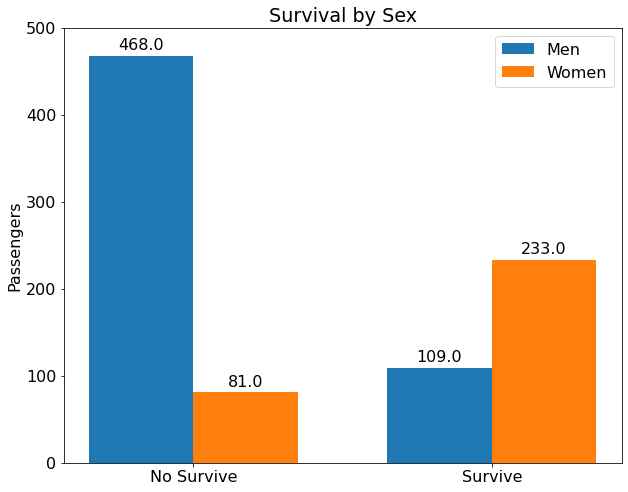

In [51]:
labels = ['No Survive', 'Survive']
male = bysex[0]
female = bysex[1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Sex')
ax.set_xticks(x)
ax.set_ylim(0,500)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

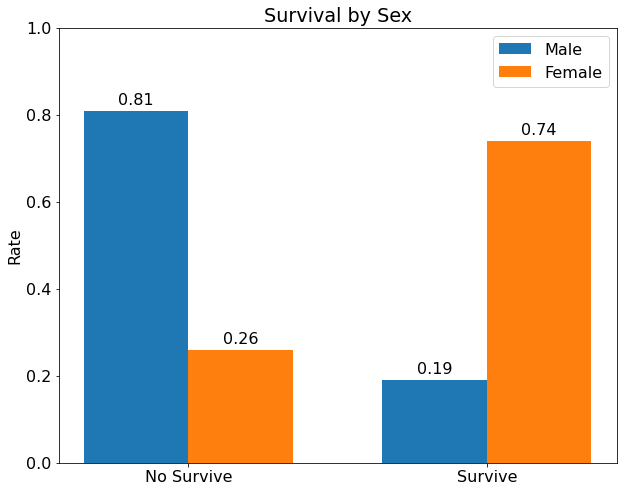

In [52]:
labels = ['No Survive', 'Survive']
male = np.round(bysex[0]/np.sum(bysex[0]),2)
female = np.round(bysex[1]/np.sum(bysex[1]),2)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, male, width, label='Male')
rects2 = ax.bar(x + width/2, female, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate')
ax.set_title('Survival by Sex')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.show()

In [53]:
df_train['male'] = df_train['Sex'] == 'male'
df_train['male'].replace([True,False],[1,0],inplace=True)
X = np.array(df_train['male'])
y = np.array(df_train['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [54]:
stats.pearsonr(X,y)

(-0.5433513806577572, 1.406066130876717e-69)

#### Discussion
There is a statistically significant indirect correlation between being a male and survival. Our model should include whether or not the passenger is male.

# BY PORT of EMBARKATION


In [55]:
df_train['Embarked'].replace(np.nan,'S',inplace=True)
ports = df_train['Embarked'].unique()

In [56]:
byport = np.zeros((len(ports),2))
byport
for i in range(0,len(ports)):
    byport[i] = df_train[df_train['Embarked'] == ports[i]]['Survived'].value_counts().sort_index()

In [57]:
print('Survival rate of:')
for i in range(0,len(ports)):
    print(f'\t{ports[i]}: {byport[i][1]/np.sum(byport[i]):.2f}')

Survival rate of:
	S: 0.34
	C: 0.55
	Q: 0.39


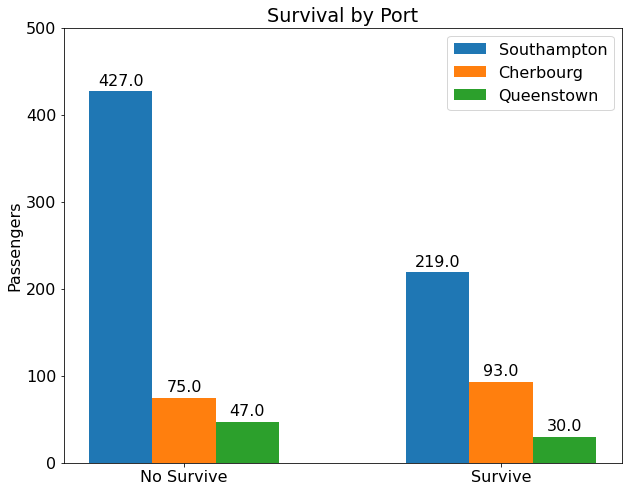

In [58]:
labels = ['No Survive', 'Survive']
S = byport[0]
C = byport[1]
Q = byport[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, S, width, label='Southampton')
rects2 = ax.bar(x , C, width, label='Cherbourg')
rects3 = ax.bar(x + width, Q, width, label='Queenstown')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Port')
ax.set_xticks(x)
ax.set_ylim(0,500)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

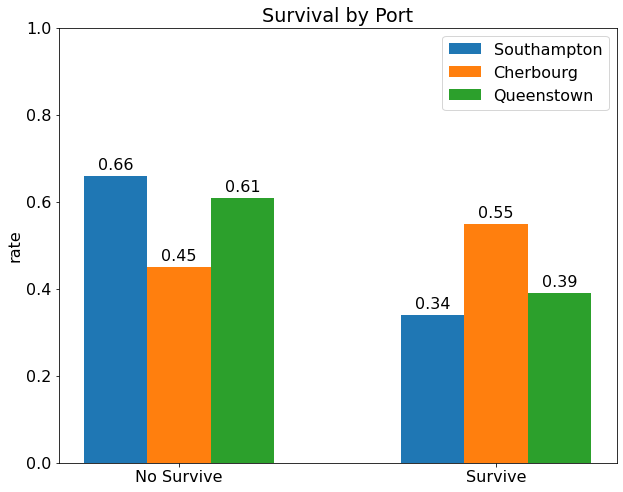

In [59]:
labels = ['No Survive', 'Survive']
S = np.round(byport[0]/np.sum(byport[0]),2)
C = np.round(byport[1]/np.sum(byport[1]),2)
Q = np.round(byport[2]/np.sum(byport[2]),2)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, S, width, label='Southampton')
rects2 = ax.bar(x , C, width, label='Cherbourg')
rects3 = ax.bar(x + width, Q, width, label='Queenstown')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rate')
ax.set_title('Survival by Port')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

In [60]:
portdum = pd.get_dummies(df_train['Embarked'])
ports = np.array(portdum.columns)
X = np.array(portdum)
for i in range(0,3):
    print(f'Embarked {ports[i]}:')
    print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.3f}')
    print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.3e}')
    print()

Embarked C:
	corr 0.168
	p-value 4.397e-07

Embarked Q:
	corr 0.004
	p-value 9.134e-01

Embarked S:
	corr -0.150
	p-value 7.223e-06



#### Discussion
These values suggest that embarking at Cherbourg has a statistically significant direct correlation with surviving. Southampton has a similar indirect correlation. There is no statisically significant correlation between embarking at Queenstown and survival. Our model should include whether the passenger embarked at Cherbourg or Southampton.

# BY DECK

In [61]:
df_train[0:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0


In [62]:
df_train['Cabin'].replace(np.nan,'??',inplace=True)
def get_deck(cabin):
    return str(cabin)[0]
df_train['deck'] = df_train['Cabin'].apply(get_deck)

In [63]:
decks = df_train['deck'].unique()
decks.sort()

In [64]:
bydeck = np.zeros((len(decks),2))
for i in range(0,len(decks)):
    if len(df_train[df_train['deck'] == decks[i]]['Survived']) > 1:
        bydeck[i] = df_train[df_train['deck'] == decks[i]]['Survived'].value_counts().sort_index()
    elif df_train[df_train['deck'] == decks[8]]['Survived'].value_counts().index[0] == 0:
        bydeck[i] = [df_train[df_train['deck'] == decks[8]]['Survived'].value_counts(),0]

In [65]:
print('Survival rate of:')
for i in range(0,len(decks)):
    print(f'\tDeck {decks[i]}: {bydeck[i][1]/np.sum(bydeck[i]):.2f}')

Survival rate of:
	Deck ?: 0.30
	Deck A: 0.47
	Deck B: 0.74
	Deck C: 0.59
	Deck D: 0.76
	Deck E: 0.75
	Deck F: 0.62
	Deck G: 0.50
	Deck T: 0.00


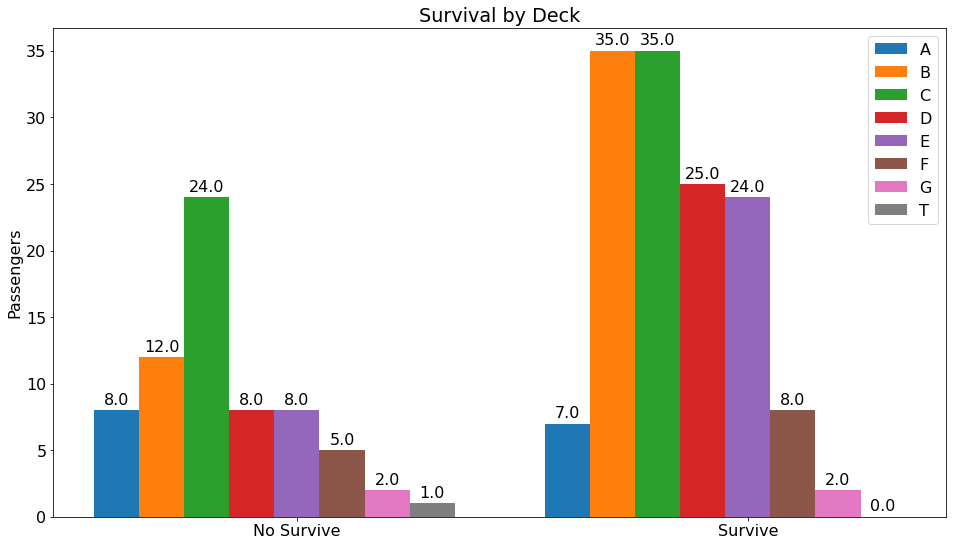

In [66]:
labels = ['No Survive', 'Survive']

x = np.arange(0,2)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))

for i in range(1,len(decks)):
    b = ax.bar(x + (i-5)*width/5, bydeck[i], width/5, label=decks[i])
    autolabel(b)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Deck')
ax.set_xticks(x)
#ax.set_ylim(0,505)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [67]:
# A snippet to generate distinct colors for our clusters.
import colorsys
N = 2*len(np.unique(decks))
print('colors: {}'.format(N))
rgb_list = []
HSV_tuples = []
for x in range(1,N+1):
    if (x%2 == 0):
        HSV_tuples.append(((x-1)*1.0/N, 1.0, 0.325))
    else:
        HSV_tuples.append((x*1.0/N, 1.0, 0.75))
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
for rgb in RGB_tuples:
        color = [int(255*rgb[0]),int(255*rgb[1]),int(255*rgb[2])]
        hxstr = '#'
        for c in color:
            hxstr = hxstr + '{0:0{1}X}'.format(c,2)
        rgb_list.append(hxstr)    


colors: 18


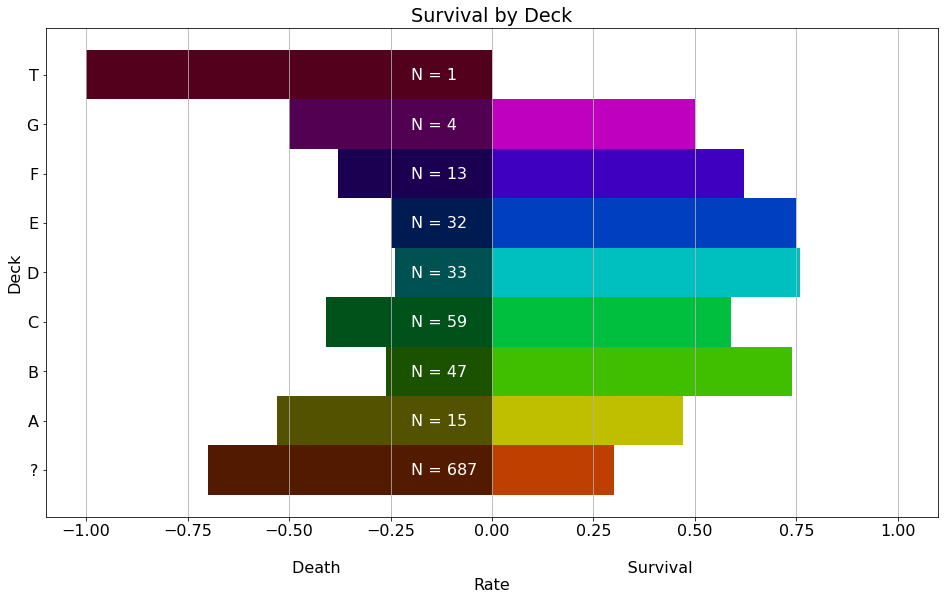

In [68]:
x = np.arange(-2.0,2.0)  # the label locations
width = 5.0  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects = []
for i in range(0,len(decks)):
    b = plt.barh(i, np.round(bydeck[i,1]/np.sum(bydeck[i]),2), width/5, label=decks[i],color=rgb_list[2*i])
    nb = plt.barh(i, -np.round(bydeck[i,0]/np.sum(bydeck[i]),2), width/5, label=decks[i],color=rgb_list[2*i+1])
    plt.annotate(f'N = {str(int(np.sum(bydeck[i])))}',xy=[-0.20,i-0.1],c='white')
    rects.append(b)
ax.set_xlabel('\nDeath                                                        Survival\nRate')
ax.set_ylabel('Deck')
ax.set_title('Survival by Deck')
ax.set_yticks(range(0,9))
ax.set_xlim(-1.1,1.1)
ax.set_yticklabels(decks)
ax.grid(axis='x')
plt.show()

In [366]:
deckdum = pd.get_dummies(df_train['deck'])
decks = np.array(deckdum.columns)
X = np.array(deckdum)
for i in range(0,len(decks)):
    pr = stats.pearsonr(X[:,i],y)
    significant = ( pr[1] < 0.05)
    if significant:
        print(f'Deck {decks[i]} ')
        print(f'\tcorr {pr[0]:.3f}')
        print(f'\tp-value {pr[1]:.3e}')
        print(f'\tSignificant: {significant}')
        print('+------------------------+')

Deck ? 
	corr -0.317
	p-value 3.091e-22
	Significant: True
+------------------------+
Deck B 
	corr 0.175
	p-value 1.442e-07
	Significant: True
+------------------------+
Deck C 
	corr 0.115
	p-value 6.062e-04
	Significant: True
+------------------------+
Deck D 
	corr 0.151
	p-value 6.233e-06
	Significant: True
+------------------------+
Deck E 
	corr 0.145
	p-value 1.332e-05
	Significant: True
+------------------------+


#### Discussion
There is a statistically significant correlation between staying on Deck B, C, D, E and survival. Conversely, if the deck of the passenger is unknown there is a correlation with not surviving. There is no significant correlation for the other decks A, F, G, & T. The significant decks should be included in our model.

# BY AGE

In [436]:
df_train[df_train['Age'].isnull()].sort_values('family')[0:50]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,deck,family
168,169,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,??,S,1,?,Baumann
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,??,C,0,?,Boulos
598,599,0,3,"Boulos, Mr. Hanna",male,NaN,0,0,2664,7.2250,??,C,1,?,Boulos
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,??,Q,0,?,Bourke
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,??,S,1,?,Bradley
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,??,C,1,?,Brewe
270,271,0,1,"Cairns, Mr. Alexander",male,NaN,0,0,113798,31.0000,??,S,1,?,Cairns
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,??,S,1,?,Campbell
578,579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,??,C,0,?,Caram
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,0,E,Chibnall


37 [ 0.          2.16216216  4.32432432  6.48648649  8.64864865 10.81081081
 12.97297297 15.13513514 17.2972973  19.45945946 21.62162162 23.78378378
 25.94594595 28.10810811 30.27027027 32.43243243 34.59459459 36.75675676
 38.91891892 41.08108108 43.24324324 45.40540541 47.56756757 49.72972973
 51.89189189 54.05405405 56.21621622 58.37837838 60.54054054 62.7027027
 64.86486486 67.02702703 69.18918919 71.35135135 73.51351351 75.67567568
 77.83783784]
38
[  0  24  16   7   7  10   5  14  30  51  40  43  54  61  47  37  33  41
  17  35  18  21  14  15  17  15   7   7   6   7   4   4   0   5   0   1
   0 178]


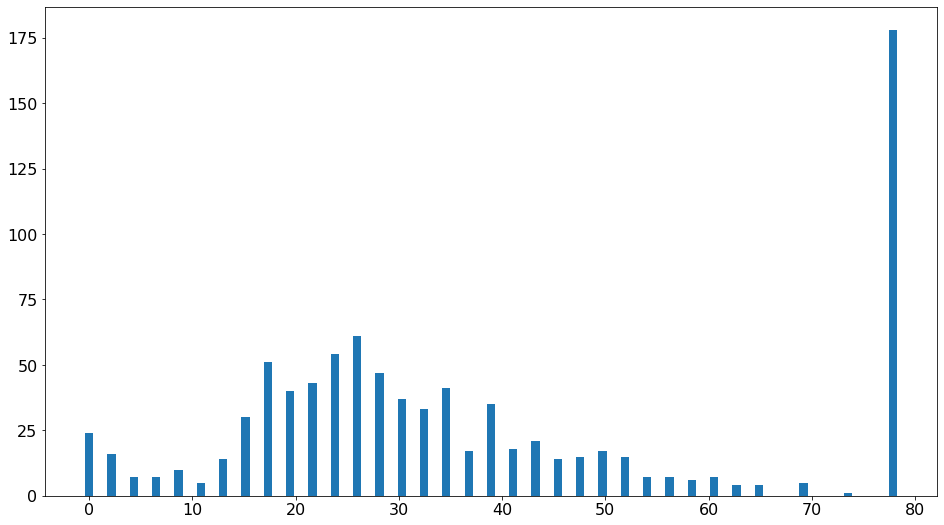

In [422]:
ylim = df_train['Age'].max()
nbins = 37

thebins = np.arange(0,ylim,ylim/nbins)
thedigital = np.digitize(df_train['Age'],thebins,right=True)
thecount = np.bincount(thedigital)
print(len(thebins),thebins)
print(len(thecount))
plt.figure(figsize=(16,9))
plt.bar(thebins,thecount[1:])
print(thecount)

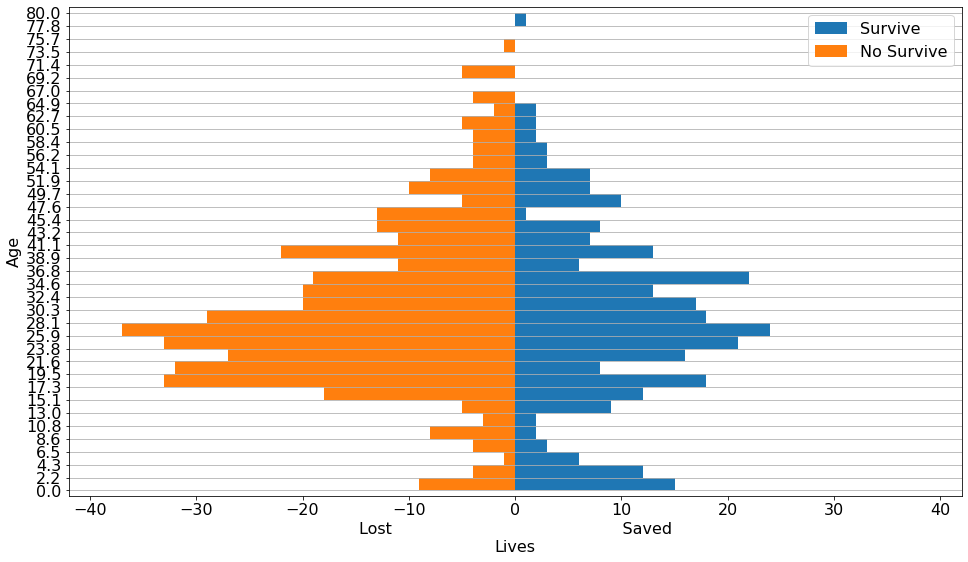

[ 0.          2.16216216  4.32432432  6.48648649  8.64864865 10.81081081
 12.97297297 15.13513514 17.2972973  19.45945946 21.62162162 23.78378378
 25.94594595 28.10810811 30.27027027 32.43243243 34.59459459 36.75675676
 38.91891892 41.08108108 43.24324324 45.40540541 47.56756757 49.72972973
 51.89189189 54.05405405 56.21621622 58.37837838 60.54054054 62.7027027
 64.86486486 67.02702703 69.18918919 71.35135135 73.51351351 75.67567568
 77.83783784 80.        ]


In [115]:
ylim = df_train['Age'].max()
nbins = 37#np.round(np.sqrt(len(df_train))).astype(int)

freq_die, bins = np.histogram(df_train[df_train['Survived'] == 0]['Age'],bins=nbins,range=[0,ylim])
freq_sur, bins = np.histogram(df_train[df_train['Survived'] == 1]['Age'],bins=nbins,range=[0,ylim])

height=ylim/nbins
xlim = freq_die.max() + 5

fig, ax = plt.subplots(figsize=(16,9))
ax.set_ylim([-1,ylim+1])
ax.set_xlim([-xlim,xlim])
ax.barh(bins[0:nbins]+height/2,freq_sur,height=height)
ax.barh(bins[0:nbins]+height/2,-freq_die,height=height)
ax.legend(['Survive','No Survive'])
ax.set_yticks(bins)
ax.set_yticklabels(np.round(bins,1))#.astype(int))
ax.set_ylabel('Age')
ax.set_xlabel('Lost                                             Saved\nLives')
plt.grid(axis='y')
plt.show()
print(bins)

In [360]:
age_arr = np.zeros((len(df_train),len(bins)))

for i in range(0,len(df_train)):
    for j in range(0,len(bins)):
        if df_train['Age'][i] <= bins[j]:
            age_arr[i,j] = 1
            break

In [ ]:
ylim = df_train['Age'].max()
binsvsppl = []

for nb in range(1,int(df_train['Age'].max())):
    freq_die, bins = np.histogram(df_train[df_train['Survived'] == 0]['Age'],bins=nb,range=[0,ylim])
    age_arr = np.zeros((len(df_train),len(bins)))
    for i in range(0,len(df_train)):
        for j in range(0,len(bins)):
            if df_train['Age'][i] <= bins[j]:
                age_arr[i,j] = 1
                break
    X = age_arr
    nsignificant = 0
    for i in range(0,len(bins)):
        if stats.pearsonr(X[:,i],y)[1] < 0.05:
            nsignificant = nsignificant + np.sum(X[:,i])
    binsvsppl.append(nsignificant)
print('Done')

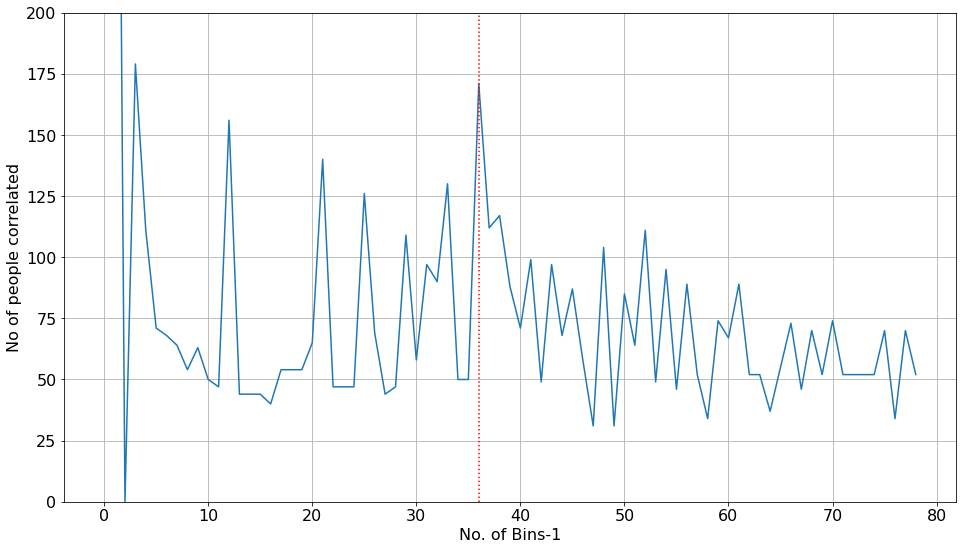

In [356]:
plt.figure(figsize=(16,9))
plt.plot(binsvsppl)
plt.ylim([0,200])
plt.grid('x')
plt.axvline(36,c='r',linestyle=':')
plt.xlabel('No. of Bins-1')
plt.ylabel('No of people correlated')
plt.show()

In [331]:
X = age_arr
total = 0
for i in range(0,len(bins)):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'Age {bins[i-1]:.1f} - {bins[i]:.1f} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.3f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.3e}')
        print(f'\tSignificant: {significant}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

NameError: name 'age_arr' is not defined

# BY TICKET PREFIX

In [355]:
def get_prefix(PD_SERIES):
    splt = PD_SERIES.split(' ')
    tmp = splt
    if len(splt) > 1:      
        tmp = splt[0]
        tmp = tmp.replace('STON/O2','SOTON/O2')
        tmp = tmp.replace('STON/O','SOTON/O2')
        tmp = tmp.replace('O2.','O2')
        #tmp = tmp.replace('.','')
        tmp = tmp.upper()
    else:
        tmp = ''
    return tmp

In [358]:
df_train['Ticket'].apply(get_prefix).value_counts()


              665
PC             60
C.A.           27
SOTON/O2       20
A/5            10
SC/PARIS        9
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
S.O.C.          5
F.C.C.          5
C               5
S.O./P.P.       3
A/4.            3
SC/AH           3
PP              3
A/4             3
A.5.            2
P/PP            2
S.C./PARIS      2
A./5.           2
WE/P            2
S.P.            1
C.A./SOTON      1
S.W./PP         1
W.E.P.          1
SCO/W           1
S.C./A.4.       1
SO/C            1
SC              1
F.C.            1
A/S             1
S.O.P.          1
W/C             1
FA              1
SW/PP           1
A4.             1
Name: Ticket, dtype: int64

In [359]:
893-665

228

In [354]:
df_train[df_train['Ticket'].str.contains('PC')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
64,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
139,140,0,1,"Giglio, Mr. Victor",male,24.0,0,0,PC 17593,79.2000,B86,C


In [114]:
PC = len(df_train[df_train['Ticket'].str.replace('.','').str.contains('PC')])
PC_s =len(df_train[(df_train['Ticket'].str.replace('.','').str.contains('PC'))&(df_train['Survived'] == 1)])
PC_s/PC

0.65

In [41]:
i=0
prefixes = []
for each in df_train['Ticket'].apply(lambda x: x.split(' ')):
    if len(each) !=1:
        prefixes.append(each[0])
        i = i+1
        
i

226

In [119]:
df2 = pd.DataFrame(prefixes)[0].value_counts()
df2

PC            60
C.A.          27
STON/O        12
A/5           10
W./C.          9
SOTON/O.Q.     8
CA.            8
A/5.           7
SOTON/OQ       7
STON/O2.       6
CA             6
S.O.C.         5
C              5
F.C.C.         5
SC/PARIS       5
SC/Paris       4
A/4.           3
S.O./P.P.      3
SC/AH          3
A/4            3
PP             3
WE/P           2
S.C./PARIS     2
SOTON/O2       2
A.5.           2
A./5.          2
P/PP           2
SCO/W          1
SC             1
W.E.P.         1
S.W./PP        1
A/S            1
C.A./SOTON     1
Fa             1
SO/C           1
SW/PP          1
S.C./A.4.      1
F.C.           1
S.P.           1
W/C            1
S.O.P.         1
A4.            1
Name: 0, dtype: int64

# BY NICKNAME

In [24]:
df_train['nickname'] = df_train['Name'].str.contains ('"')
df_train['nickname'].value_counts()

False    838
True      53
Name: nickname, dtype: int64

In [25]:
hasnickname = [True, False]
bynickname = np.zeros((2,2))
for i in range(0,len(hasnickname)):
    bynickname[i] = df_train[df_train['nickname'] == hasnickname[i]]['Survived'].value_counts().sort_index()
bynickname

array([[ 15.,  38.],
       [534., 304.]])

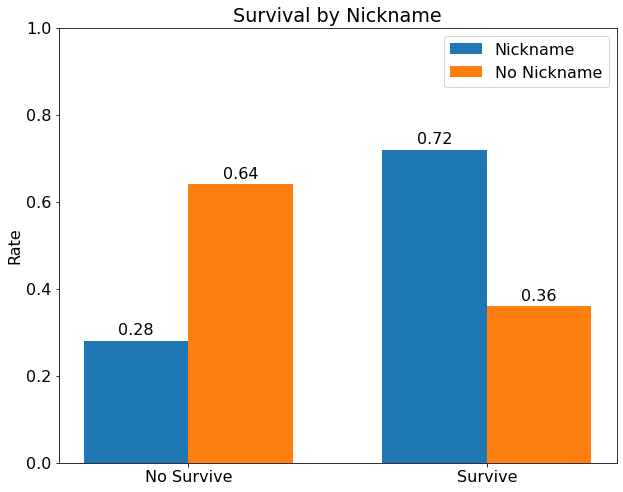

In [26]:
labels = ['No Survive', 'Survive']
nname = bynickname[0]
nonname = bynickname[1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, np.round(nname/np.sum(bynickname[0]),2), width, label='Nickname')
rects2 = ax.bar(x + width/2, np.round(nonname/np.sum(bynickname[1]),2), width, label='No Nickname')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate')
ax.set_title('Survival by Nickname')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()


autolabel(rects1)
autolabel(rects2)

plt.show()

# BY FAMILYNAME

In [430]:
df_train['family'] = df_train['Name'].apply(lambda x: x.split(',')[0])
df_train['family'].value_counts()

Andersson    9
Sage         7
Johnson      6
Carter       6
Goodwin      6
            ..
Butler       1
Weisz        1
O'Dwyer      1
Thorne       1
Najib        1
Name: family, Length: 667, dtype: int64

In [431]:
names = list(df_train['family'].value_counts().index)

In [432]:
dtype = [('index', int ), ('died', int), ('survived', int)]
byname = np.array((1+len(names),3),dtype=dtype)
for i in range(0,len(names)):
    if len(df_train[df_train['family'] == names[i]]['Survived'].value_counts().sort_index()) == 2:
        byname[i] = i, df_train[df_train['family'] == names[i]]['Survived'].value_counts().sort_index()[0], df_train[df_train['family'] == names[i]]['Survived'].value_counts().sort_index()[1]
    elif df_train[df_train['family'] == names[i]]['Survived'].value_counts().index[0] == 0:
        byname[i] = i, df_train[df_train['family'] == names[i]]['Survived'].value_counts(), 0
    else:
        byname[i] = i, 1, df_train[df_train['family'] == names[i]]['Survived'].value_counts()


ValueError: could not assign tuple of length 2 to structure with 3 fields.

In [134]:
df_train[df_train['family'] == 'Lefebre']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck,nickname,title,family
176,177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,??,S,?,False,Master,Lefebre
229,230,0,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,??,S,?,False,Miss,Lefebre
409,410,0,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,??,S,?,False,Miss,Lefebre
485,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,??,S,?,False,Miss,Lefebre


# BY TITLE

In [27]:
df_train['title'] = df_train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(' ',''))
df_train['title'].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Col              2
Major            2
Mlle             2
Ms               1
Lady             1
theCountess      1
Capt             1
Mme              1
Don              1
Jonkheer         1
Sir              1
Name: title, dtype: int64

In [28]:
miss = ['Ms','Mlle']
mrs = ['Mme', 'Lady']
#prestigious = ['Dr','Rev','Major','Col','Sir','theCountess','Capt','Jonkheer','Don']
noble = ['Sir','theCountess','Jonkheer','Don']
officer = ['Major','Col','Capt']
professional = ['Dr','Rev']

df_train['title'] = df_train['title'].replace(miss,'Miss')
df_train['title'] = df_train['title'].replace(mrs,'Mrs')
df_train['title'] = df_train['title'].replace(noble,'Nobility')
df_train['title'] = df_train['title'].replace(officer,'Officer')
df_train['title'] = df_train['title'].replace(professional,'Professional')

In [29]:
df_train['title'].value_counts()

Mr              517
Miss            185
Mrs             127
Master           40
Professional     13
Officer           5
Nobility          4
Name: title, dtype: int64

In [30]:
titles = list(df_train['title'].value_counts().index)


In [31]:
bytitle = np.zeros((len(titles),2))
for i in range(0,len(titles)):
    bytitle[i] = df_train[df_train['title'] == titles[i]]['Survived'].value_counts().sort_index()

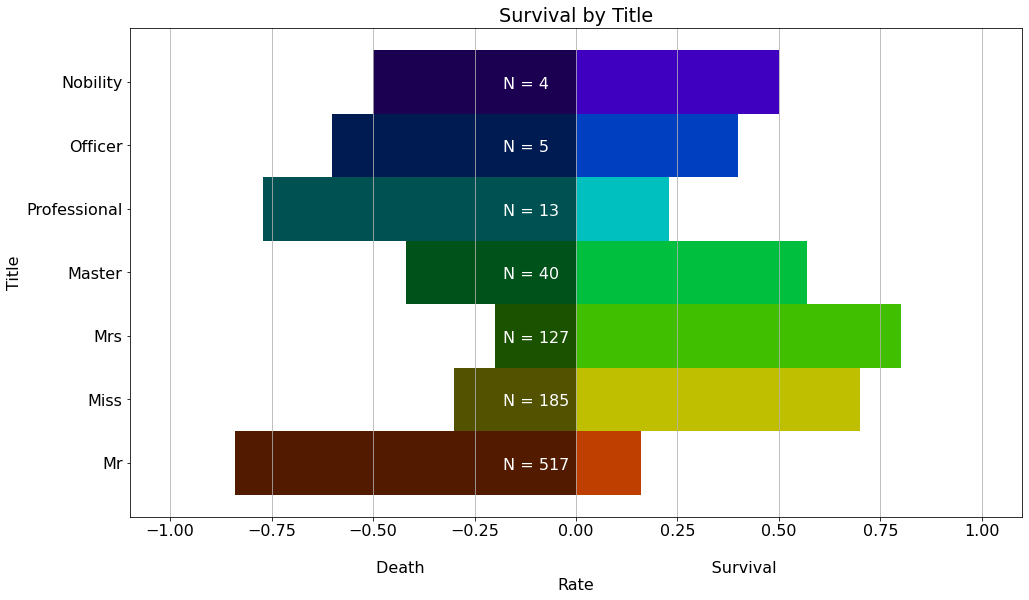

In [32]:
x = np.arange(-2.0,2.0)  # the label locations
width = 5.0  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects = []
for i in range(0,len(titles)):
    b = plt.barh(i, np.round(bytitle[i,1]/np.sum(bytitle[i]),2), width/5, label=titles[i],color=rgb_list[2*i])
    nb = plt.barh(i, -np.round(bytitle[i,0]/np.sum(bytitle[i]),2), width/5, label=titles[i],color=rgb_list[2*i+1])
    rects.append(b)
    plt.annotate(f'N = {str(int(np.sum(bytitle[i])))}',xy=[-0.18,i-0.1],c='white')
ax.set_xlabel('\nDeath                                                        Survival\nRate')
ax.set_ylabel('Title')
ax.set_title('Survival by Title')
ax.set_yticks(range(0,7))
ax.set_xlim(-1.1,1.1)
ax.set_yticklabels(titles)
ax.grid(axis='x')
plt.show()

# BY SIBSP

In [39]:
df_train['SibSp'].value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

In [33]:
sbsps = np.array(df_train['SibSp'].value_counts().sort_index().index)
bysbsp = np.zeros([len(sbsps),2])
for i in range(0,len(sbsps)):
    bysbsp[i] = df_train[df_train['SibSp'] == sbsps[i]]['Survived'].value_counts().sort_index()

In [34]:
print('Survival rate of SibSp')
for i in range(0,len(sbsps)):
    print(f'\t = {sbsps[i]}: {bysbsp[i][1]/np.sum(bysbsp[i]):.2f}')

Survival rate of SibSp
	 = 0: 0.35
	 = 1: 0.54
	 = 2: 0.46
	 = 3: 0.25
	 = 4: 0.17
	 = 5: 0.50
	 = 8: 0.50


# BY PARCH

In [35]:
parchs = np.array(df_train['Parch'].value_counts().sort_index().index)
byparch = np.zeros([len(parchs),2])
for i in range(0,len(parchs)):
    byparch[i] = df_train[df_train['Parch'] == parchs[i]]['Survived'].value_counts().sort_index()

In [36]:
print('Survival rate of: Parch')
for i in range(0,len(parchs)):
    print(f'\t = {parchs[i]}: {byparch[i][1]/np.sum(byparch[i]):.2f}')

Survival rate of: Parch
	 = 0: 0.34
	 = 1: 0.55
	 = 2: 0.50
	 = 3: 0.60
	 = 4: 0.50
	 = 5: 0.20
	 = 6: 0.50
